# Pre-processing of avalanche warning data for machine learning


In [1]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="white")
#from sklearn.preprocessing import LabelEncoder
#from pprint import pprint

pd.set_option("display.max_rows",6)

%matplotlib inline

In [2]:
# analysis of entire data set
varsom_df = pd.read_csv(r'..\..\data\varsom\norwegian_avalanche_warnings_season_17_18.csv', index_col=0)
varsom_df.head()

,author,avalanche_danger,avalanche_problem_1_advice,avalanche_problem_1_cause_id,avalanche_problem_1_cause_name,avalanche_problem_1_destructive_size_ext_id,avalanche_problem_1_destructive_size_ext_name,avalanche_problem_1_distribution_id,avalanche_problem_1_distribution_name,avalanche_problem_1_exposed_height_1,...,region_id,region_name,region_type_id,region_type_name,snow_surface,utm_east,utm_north,utm_zone,valid_from,valid_to
index,,,,,,,,,,,,,,,,,,,,,
0,Karsten@NVE,Det er lite snø og generelt stabile forhold i ...,Vær varsom der skredproblemet er å finne i ko...,15,Dårlig binding mellom lag i fokksnøen,2,2 - Middels,1,Få bratte heng,0,...,3003,Nordenskiöld Land,10,A,Det er generelt lite snø i terrenget. Rygger e...,520332,8663904,33,2017-12-01 00:00:00,2017-12-01 23:59:59
1,jan arild@obskorps,Kraftig vind fra sørøst vil gi pålagring av fe...,Vær forsiktig i områder brattere enn 30 grader...,10,Nedføyket svakt lag med nysnø,2,2 - Middels,2,Noen bratte heng,400,...,3007,Vest-Finnmark,10,A,Siste dagene har det kommet 25-30 cm snø utsat...,802123,7794717,33,2017-12-01 00:00:00,2017-12-01 23:59:59
2,jan arild@obskorps,"Generelle stabile forhold, men vindøkning fra ...",Vær forsiktig i områder brattere enn 30 grader...,10,Nedføyket svakt lag med nysnø,2,2 - Middels,2,Noen bratte heng,400,...,3009,Nord-Troms,10,A,Siste dagene har det kommet 20-30 cm snø utsat...,750984,7742562,33,2017-12-01 00:00:00,2017-12-01 23:59:59
3,jan arild@obskorps,Vindøkning fra sør vil gi pålagring av fersk f...,Vær forsiktig i områder brattere enn 30 grader...,10,Nedføyket svakt lag med nysnø,2,2 - Middels,2,Noen bratte heng,400,...,3010,Lyngen,10,A,Siste dagene har det kommet 10-20 cm snø utsat...,692056,7719872,33,2017-12-01 00:00:00,2017-12-01 23:59:59
4,jan arild@obskorps,Kraftig vind fra sør vil gi pålagring av fersk...,Vær forsiktig i områder brattere enn 30 grader...,10,Nedføyket svakt lag med nysnø,2,2 - Middels,2,Noen bratte heng,400,...,3011,Tromsø,10,A,Siste dagene har det kommet 25-40 cm snø utsat...,656496,7764237,33,2017-12-01 00:00:00,2017-12-01 23:59:59


Check if there are missing values.

In [3]:
str(varsom_df['region_id'][0])

'3003'

In [4]:
# Find the amount of NaN values in each column
print(varsom_df.isnull().sum().sort_values(ascending=False))

mountain_weather_change_wind_direction       2509
mountain_weather_change_hour_of_day_start    2491
mountain_weather_change_hour_of_day_stop     2491
                                             ... 
avalanche_problem_3_probability_name            0
avalanche_problem_3_problem_id                  0
author                                          0
Length: 101, dtype: int64


Fill missing values where necessary.

In [5]:
varsom_df['mountain_weather_wind_speed'] = varsom_df['mountain_weather_wind_speed'].fillna('None')
varsom_df['mountain_weather_wind_direction'] = varsom_df['mountain_weather_wind_direction'].fillna('None')
print(varsom_df.isnull().sum().sort_values(ascending=False))

mountain_weather_change_wind_direction       2509
mountain_weather_change_hour_of_day_stop     2491
mountain_weather_change_hour_of_day_start    2491
                                             ... 
avalanche_problem_3_problem_id                  0
avalanche_problem_3_problem_type_id             0
author                                          0
Length: 101, dtype: int64


## Feature engineering
Re-label og -classifiy variables where necessary.

In [6]:
from regroup_forecast import regroup

varsom_df = regroup(varsom_df)

Hot encode categorial variables where necessary.

In [7]:
# hot encode
hot_encode_ = ['emergency_warning', 'author', 'mountain_weather_wind_direction']
varsom_df = pd.get_dummies(varsom_df, columns=hot_encode_)

Check if there are no weired or missing values.

In [8]:
# Check if there are no weired or missing values.
for col in varsom_df.columns.values:
    print(f'{col}: {varsom_df[col].unique()} \n')

avalanche_danger: ['Det er lite snø og generelt stabile forhold i regionen. Det er kun i enkelte bratte leformasjoner som har samlet mye snø at det er mulig å løse ut snøskred.'
 'Kraftig vind fra sørøst vil gi pålagring av fersk fokksnø som vil trenge tid til å stabilisere seg. Det er fortsatt lett å løse ut skred i fokksnøen de steder hvor denne fokksnøen har lagt seg. Det finnes også vedvarende svake lag av kantkorn som er med på å styre skredfaren.\r\nSkredfaren vurderes til faregrad 2-moderat for regionen som helhet. '
 'Generelle stabile forhold, men vindøkning fra sør vil gi pålagring av fersk fokksnø i leområder. Skred i dette kan lett løses ut de steder hvor fokksnøen legger seg. Skredfaren styres også av utbredelse av kantkornlag som er observert i deler av regionen. Skred på dette kan lett løses ut hvor snødekket er tynt.\r\nSkredfaren vurderes til faregrad 2-moderat for regionen.'
 ...
 'Regionen har generelt stabile forhold med et forutsigbart snødekke som har gjennomgått 

Remove variables we know we do not need. In this case mainly because they are redundant like the _avalanche\_problem\_1\_ext\_name_ and _avalanche\_problem\_1\_ext\_id_ - in this case we only keep the numeric _id_ variable.

In [9]:
del_list = [
    'utm_zone',
    'utm_east',
    'utm_north',
    'danger_level_name',
    'avalanche_problem_1_exposed_height_fill',
    'avalanche_problem_2_exposed_height_fill',
    'avalanche_problem_3_exposed_height_fill',
    'avalanche_problem_1_valid_expositions',
    'avalanche_problem_2_valid_expositions',
    'avalanche_problem_3_valid_expositions',
    'avalanche_problem_1_cause_name',
    'avalanche_problem_1_problem_type_name',
    'avalanche_problem_1_destructive_size_ext_name',
    'avalanche_problem_1_distribution_name',
    'avalanche_problem_1_ext_name',
    'avalanche_problem_1_probability_name',
    'avalanche_problem_1_trigger_simple_name',
    'avalanche_problem_1_type_name',
    'avalanche_problem_2_cause_name',
    'avalanche_problem_2_problem_type_name',
    'avalanche_problem_2_destructive_size_ext_name',
    'avalanche_problem_2_distribution_name',
    'avalanche_problem_2_ext_name',
    'avalanche_problem_2_probability_name',
    'avalanche_problem_2_trigger_simple_name',
    'avalanche_problem_2_type_name',
    'avalanche_problem_3_cause_name',
    'avalanche_problem_3_problem_type_name',
    'avalanche_problem_3_destructive_size_ext_name',
    'avalanche_problem_3_distribution_name',
    'avalanche_problem_3_ext_name',
    'avalanche_problem_3_probability_name',
    'avalanche_problem_3_trigger_simple_name',
    'avalanche_problem_3_type_name',
    'latest_avalanche_activity',
    'main_text',
    'snow_surface',
    'current_weak_layers',
    'avalanche_danger',
    'avalanche_problem_1_advice',
    'avalanche_problem_2_advice',
    'avalanche_problem_3_advice',
    'mountain_weather_wind_speed',
    'region_type_name',
    'region_name',
    'reg_id',
    'valid_from',
    'valid_to'
]
removed_ = [varsom_df.pop(v) for v in del_list]

Fill missing values where necessary

In [10]:
fill_list = [
    'mountain_weather_freezing_level',
    'mountain_weather_precip_region',
    'mountain_weather_precip_most_exposed',
    'mountain_weather_temperature_min',
    'mountain_weather_temperature_max',
    'mountain_weather_temperature_elevation'
]
filled_ = [varsom_df[v].fillna(0., inplace=True) for v in fill_list]

Eventually remove variables with many missing values.

In [11]:
del_list = [
    'mountain_weather_change_wind_direction',
    'mountain_weather_change_hour_of_day_start',
    'mountain_weather_change_hour_of_day_stop',
    'mountain_weather_change_wind_speed',
    'mountain_weather_fl_hour_of_day_stop',
    'mountain_weather_fl_hour_of_day_start',
    'latest_observations'
]
removed_ = [varsom_df.pop(v) for v in del_list]

Check again if there are still values missing...

In [12]:
# Find the amount of NaN values in each column
print(varsom_df.isnull().sum().sort_values(ascending=False))

mountain_weather_wind_direction_W      0
avalanche_problem_3_cause_id           0
avalanche_problem_3_distribution_id    0
                                      ..
author_Ronny@NVE                       0
author_Silje@svv                       0
avalanche_problem_1_cause_id           0
Length: 91, dtype: int64


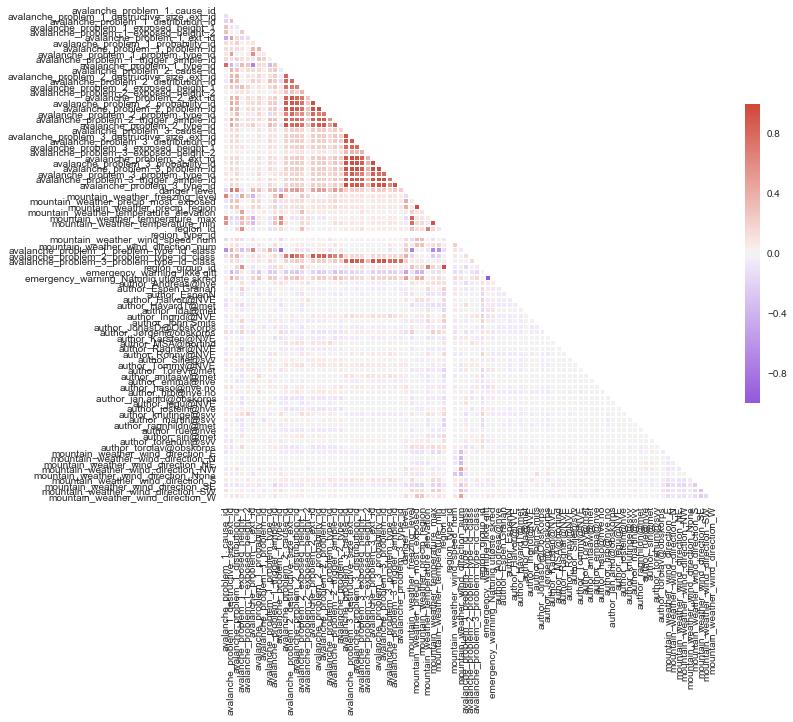

In [13]:
# Compute the correlation matrix - works only on numerical variables.
corr = varsom_df.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 11))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(1000, 15, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.8, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

We can see that some parameters are highly correlated. These are mainly the parameters belonging to the same avalanche problem. Depending on the ML algorithm we use we have to remove some of them.

In [14]:
#corr['avalanche_problem_1_cause_id'].sort_values(ascending=False)
#corr

In [15]:
#sns.pairplot(varsom_df.drop(['date_valid'], axis=1))

In [16]:
# let's see the details about remainig variables 

varsom_df.describe()

,avalanche_problem_1_cause_id,avalanche_problem_1_destructive_size_ext_id,avalanche_problem_1_distribution_id,avalanche_problem_1_exposed_height_1,avalanche_problem_1_exposed_height_2,avalanche_problem_1_ext_id,avalanche_problem_1_probability_id,avalanche_problem_1_problem_id,avalanche_problem_1_problem_type_id,avalanche_problem_1_trigger_simple_id,...,author_torolav@obskorps,mountain_weather_wind_direction_E,mountain_weather_wind_direction_N,mountain_weather_wind_direction_NE,mountain_weather_wind_direction_NW,mountain_weather_wind_direction_None,mountain_weather_wind_direction_S,mountain_weather_wind_direction_SE,mountain_weather_wind_direction_SW,mountain_weather_wind_direction_W
count,3822.000000,3822.000000,3822.000000,3822.000000,3822.000000,3822.000000,3822.000000,3822.000000,3822.000000,3822.000000,...,3822.000000,3822.000000,3822.000000,3822.000000,3822.000000,3822.000000,3822.000000,3822.000000,3822.000000,3822.000000
mean,14.857928,2.159864,1.805338,617.870225,62.611198,19.344584,3.019885,0.997907,14.845631,18.843276,...,0.040555,0.100471,0.033229,0.052329,0.066457,0.019362,0.118786,0.315542,0.170591,0.123234
std,5.313807,0.671965,0.565790,355.952656,197.157994,2.513152,0.376101,0.045709,11.530338,4.701593,...,0.197282,0.300666,0.179257,0.222718,0.249112,0.137810,0.323579,0.464792,0.376201,0.328749
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50%,13.000000,2.000000,2.000000,600.000000,0.000000,20.000000,3.000000,1.000000,10.000000,21.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,19.000000,3.000000,2.000000,900.000000,0.000000,20.000000,3.000000,1.000000,30.000000,21.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
max,24.000000,4.000000,3.000000,2100.000000,2000.000000,25.000000,5.000000,1.000000,50.000000,22.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## Save data for further analysis

In [17]:
varsom_df.to_csv('varsom_ml_preproc.csv', index_label='index')

#### Now we have clean data and can build a model

The library we'll use is called **sckit-learn**. 

http://scikit-learn.org

- Python library
- Access to well known machine learning algorithms
- Built on NumPy, SciPy, and matplotlib
- Open Source
- Well documented with many good tutorials


## Worklflow of scikit-learn

- Create model object
- .fit
- .predict
- evaluate